# Test Trained Models

This notebook tests a trained checkpoint. To run you must have the SpectralWaste Dataset installed on your computer.

In [2]:
import torch
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from spectralwaste_segmentation import models, datasets, utils

## 1. Configuration

In [3]:
DATA_PATH = 'D:/Data/spectralwaste-segmentation-data/spectralwaste_segmentation' #Path to SpectraalWate dataset
CHECKPOINT_PATH = '../results/segformer_b0.rgb.labels_rgb.8eeb.best.pth' #Path to model checkpoint

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.xpu.is_available():
    DEVICE = torch.device('xpu')
else:
    DEVICE = torch.device('cpu')

print(f'Using device: {DEVICE}')

Using device: cpu


## 2. Load Checkpoint & Build Model

In [4]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu', weights_only=False)
args = checkpoint['args']

print(f'Model      : {args.model}')
print(f'Input mode : {args.input_mode}')
print(f'Target mode: {args.target_mode}')
print(f'Epoch      : {checkpoint["epoch"]}')

Model      : segformer_b0
Input mode : rgb
Target mode: labels_rgb
Epoch      : 196


In [5]:
test_data = datasets.SpectralWasteSegmentation(
    DATA_PATH,
    split='test',
    input_mode=args.input_mode,
    target_mode=args.target_mode,
    transforms=datasets.SemanticSegmentationTest(),
    target_type=''
)

test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0)

print(f'Test samples   : {len(test_data)}')
print(f'Num classes    : {test_data.num_classes}')
print(f'Class names    : {test_data.classes_names}')
print(f'Input channels : {test_data.num_channels}')

Test samples   : 171
Num classes    : 7
Class names    : ['background', 'film', 'basket', 'cardboard', 'video_tape', 'filament', 'bag']
Input channels : 3


In [6]:
model = models.create_model(args.model, test_data.num_channels, test_data.num_classes)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model.eval()

SegFormer(
  (model): SegFormer(
    (backbone): mit_b0(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
          (attn): A

## 3. Evaluate on Test Set

Compute loss, per-class IoU, mean IoU (excluding background), and overall accuracy.

In [7]:
num_classes = test_data.num_classes
criterion = torch.nn.CrossEntropyLoss()

mean_loss = torchmetrics.MeanMetric().to(DEVICE)
class_iou = torchmetrics.JaccardIndex(
    num_classes=num_classes, task='multiclass', average='none'
).to(DEVICE)
overall_accuracy = torchmetrics.Accuracy(
    num_classes=num_classes, task='multiclass'
).to(DEVICE)

with torch.inference_mode():
    for inputs, targets in tqdm(test_loader, desc='Testing'):
        if isinstance(inputs, list):
            inputs = [x.to(DEVICE) for x in inputs]
        else:
            inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(inputs)

        mean_loss.update(criterion(outputs, targets))
        class_iou.update(outputs, targets)
        overall_accuracy.update(outputs, targets)

test_loss = mean_loss.compute().item()
test_class_iou = class_iou.compute()
test_miou = test_class_iou[1:].mean().item()  
test_iou_std = test_class_iou[1:].std().item()
test_acc = overall_accuracy.compute().item()

print(f'Test Loss      : {test_loss:.4f}')
print(f'Overall Accuracy: {test_acc:.4f}')
print(f'Mean IoU (excl bg): {test_miou:.4f} ± {test_iou_std:.4f}')

Testing:   0%|          | 0/11 [00:00<?, ?it/s]

Test Loss      : 0.2888
Overall Accuracy: 0.9074
Mean IoU (excl bg): 0.5144 ± 0.2005


### Per-Class IoU

In [8]:
print(f'{"Class":<15} {"IoU":>8}')
print('-' * 25)
for i, name in enumerate(test_data.classes_names):
    iou_val = test_class_iou[i].item()
    print(f'{name:<15} {iou_val:>8.4f}')
print('-' * 25)
print(f'{"mIoU (excl bg)":<15} {test_miou:>8.4f}')

Class                IoU
-------------------------
background        0.8996
film              0.6770
basket            0.7139
cardboard         0.6235
video_tape        0.3494
filament          0.2051
bag               0.5172
-------------------------
mIoU (excl bg)    0.5144


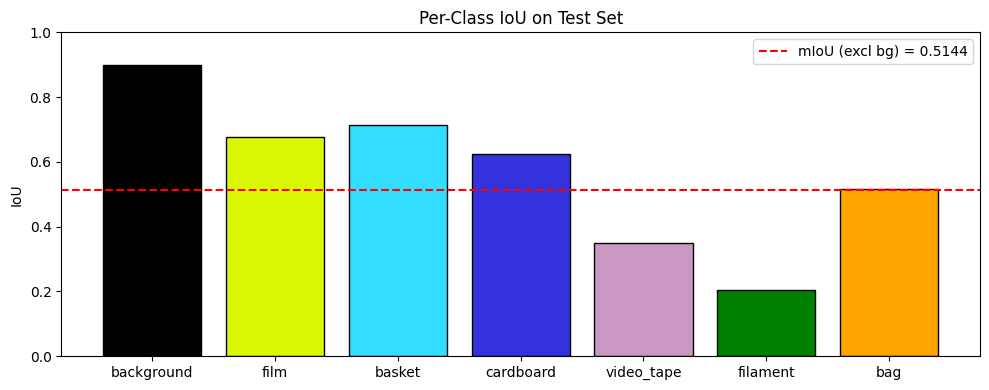

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
colors_bar = [np.array(c) / 255 for c in test_data.palette]
bars = ax.bar(test_data.classes_names, test_class_iou.cpu().numpy(), color=colors_bar, edgecolor='black')
ax.axhline(test_miou, color='red', linestyle='--', label=f'mIoU (excl bg) = {test_miou:.4f}')
ax.set_ylabel('IoU')
ax.set_title('Per-Class IoU on Test Set')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

## 4. Confusion Matrix

Confusion matrix:   0%|          | 0/11 [00:00<?, ?it/s]

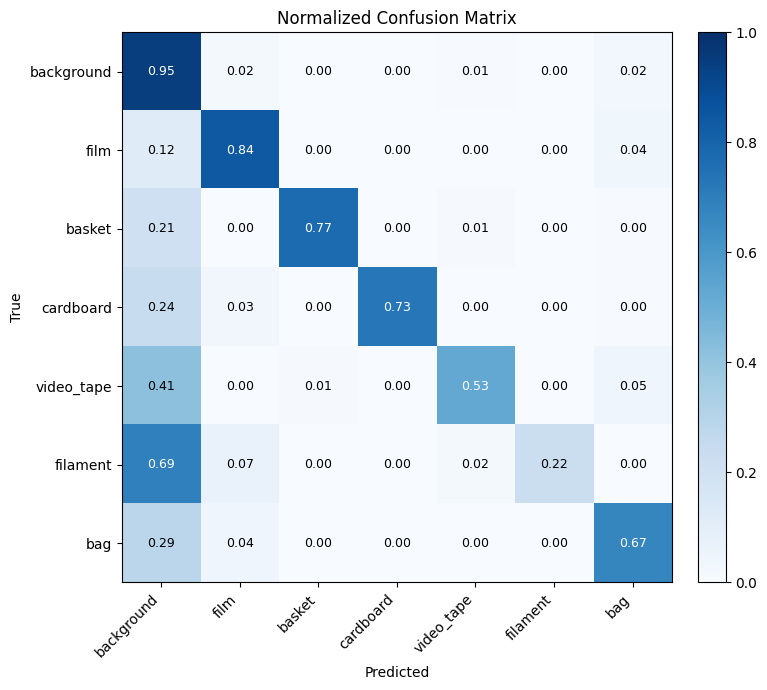

In [10]:
conf_matrix = torchmetrics.ConfusionMatrix(
    num_classes=num_classes, task='multiclass', normalize='true'
).to(DEVICE)

with torch.inference_mode():
    for inputs, targets in tqdm(test_loader, desc='Confusion matrix'):
        if isinstance(inputs, list):
            inputs = [x.to(DEVICE) for x in inputs]
        else:
            inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(inputs)
        conf_matrix.update(outputs, targets)

cm = conf_matrix.compute().cpu().numpy()

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(test_data.classes_names, rotation=45, ha='right')
ax.set_yticklabels(test_data.classes_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Normalized Confusion Matrix')

for i in range(num_classes):
    for j in range(num_classes):
        color = 'white' if cm[i, j] > 0.5 else 'black'
        ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center', color=color, fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## 5. Qualitative Results

Visualize model predictions vs ground truth on selected test images.

C:\Users\Ervin\AppData\Local\Temp\ipykernel_12728\3910622869.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


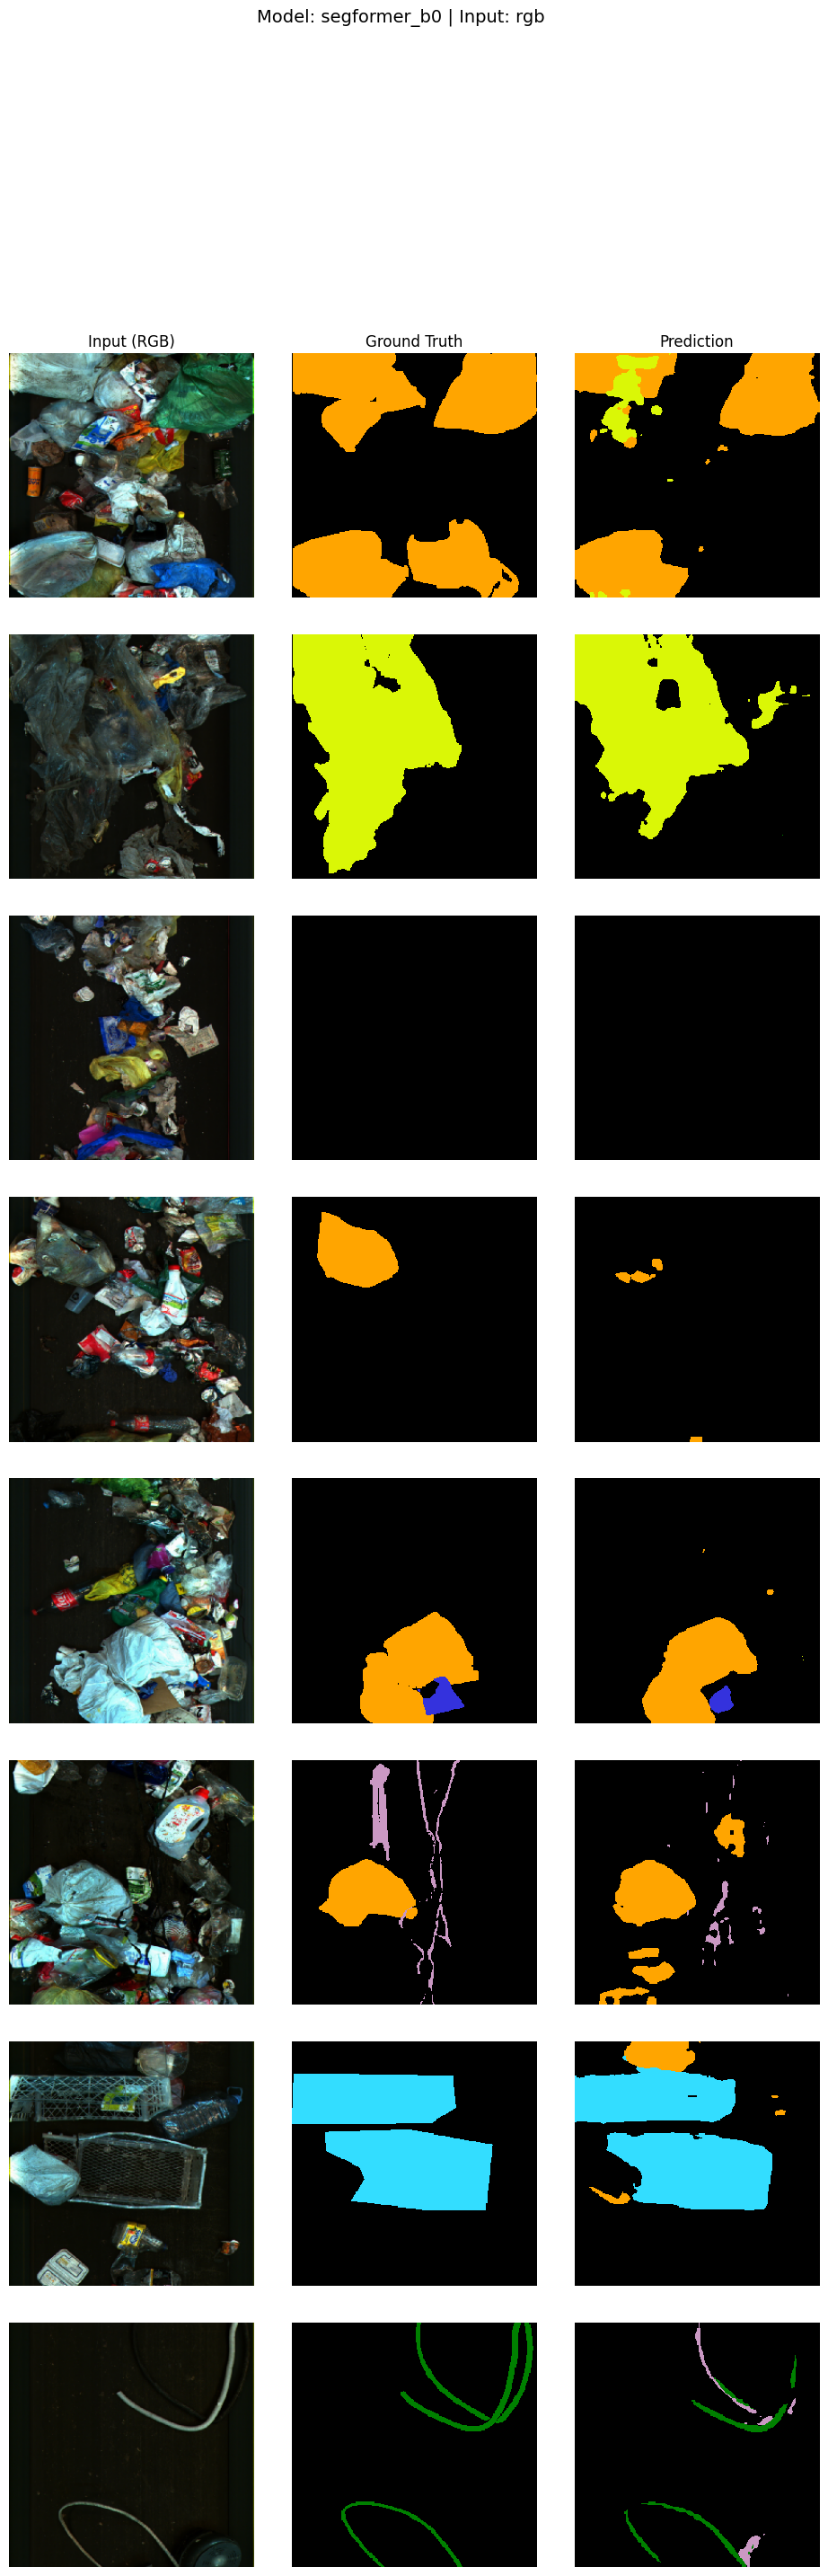

In [11]:
# Select sample indices to visualize
num_samples = min(8, len(test_data))
sample_indices = np.linspace(0, len(test_data) - 1, num_samples, dtype=int)

fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples),
                         gridspec_kw={'hspace': 0.15, 'wspace': 0.05})

if num_samples == 1:
    axs = axs[np.newaxis, :]

axs[0, 0].set_title('Input (RGB)', fontsize=12)
axs[0, 1].set_title('Ground Truth', fontsize=12)
axs[0, 2].set_title('Prediction', fontsize=12)

with torch.inference_mode():
    for row, idx in enumerate(sample_indices):
        inputs, target = test_data[idx]

        # Prepare input for model
        if isinstance(inputs, list):
            model_input = [x.unsqueeze(0).to(DEVICE) for x in inputs]
            # Use the first modality (RGB) for display
            rgb = inputs[0]
        else:
            model_input = inputs.unsqueeze(0).to(DEVICE)
            rgb = inputs

        output = model(model_input)
        pred = output.argmax(dim=1).squeeze().cpu()

        # Display RGB input (take first 3 channels if needed)
        rgb_np = rgb[:3].permute(1, 2, 0).numpy()
        rgb_np = np.clip(rgb_np, 0, 1)

        axs[row, 0].imshow(rgb_np)
        axs[row, 0].axis('off')
        axs[row, 0].set_ylabel(f'#{idx}', fontsize=10, rotation=0, labelpad=30)

        axs[row, 1].imshow(utils.get_color_labels(target.numpy(), test_data.palette), interpolation='none')
        axs[row, 1].axis('off')

        axs[row, 2].imshow(utils.get_color_labels(pred.numpy(), test_data.palette), interpolation='none')
        axs[row, 2].axis('off')

plt.suptitle(f'Model: {args.model} | Input: {args.input_mode}', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

## 6. Legend

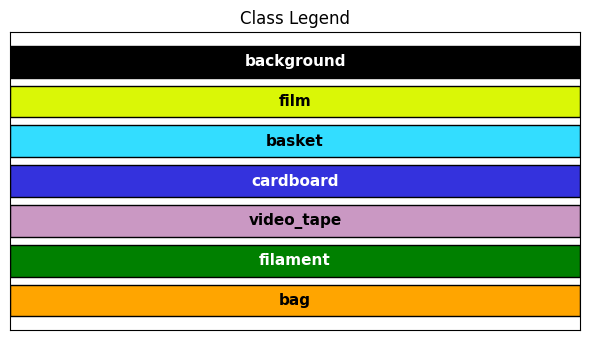

In [12]:
# Display colour legend for the segmentation classes
fig, ax = plt.subplots(figsize=(6, 0.5 * len(test_data.classes_names)))
for i, (name, color) in enumerate(zip(test_data.classes_names, test_data.palette)):
    ax.barh(i, 1, color=np.array(color) / 255, edgecolor='black')
    ax.text(0.5, i, name, ha='center', va='center', fontsize=11,
            color='white' if sum(color) < 380 else 'black', fontweight='bold')
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Class Legend')
ax.invert_yaxis()
plt.tight_layout()
plt.show()